# 4 - Ricerca regole di associazione

Il Frequent Pattern Mining si applica prevalentemente a dati transazionali e sequenziali, tipici del settore commerciale. Una delle prime applicazioni, la Market Basket Analysis (MBA), nella sua versione più semplice, lavora su un set di variabili binarie associate ad altrettanti prodotti: ogni variabile specifica la presenza (1) o l’assenza (0) del prodotto nel “carrello della spesa” di un cliente; formalmente, quindi, ogni carrello viene descritto da una sequenza di 1 e di 0, detta transazione.
Disponendo di un dataset di transazioni, si può esaminare quali (gruppi di) prodotti tendono a essere acquistati insieme.
Tale ricerca è svolta utilizzando il noto algoritmo ***Apriori***. Tale algoritmo parte dalla considerazione che se un insieme di oggetti (itemset) è frequente, allora anche tutti i suoi sottoinsiemi sono frequenti, ma se un itemset non è frequente, allora neanche gli insiemi che lo contengono sono frequenti (principio di anti-monotonicità).

# Ricerca di regole di associazione, basata sul subset contenente esclusivamente le transazioni effettuate dai primi 30 best Customers con una alta tendenza ad acquistare grandi stock di prodotti a prezzi scontati

In [1]:
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
df = pd.read_csv('best_customers_df.csv')

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536381,22139,RETROSPOT TEA SET CERAMIC 11 PC,23,2010-12-01 09:41:00,4.25,15311.0,United Kingdom,97.75
1,536381,84854,GIRLY PINK TOOL SET,5,2010-12-01 09:41:00,4.95,15311.0,United Kingdom,24.75
2,536381,22411,JUMBO SHOPPER VINTAGE RED PAISLEY,10,2010-12-01 09:41:00,1.95,15311.0,United Kingdom,19.50
3,536381,82567,"AIRLINE LOUNGE,METAL SIGN",2,2010-12-01 09:41:00,2.10,15311.0,United Kingdom,4.20
4,536381,21672,WHITE SPOT RED CERAMIC DRAWER KNOB,6,2010-12-01 09:41:00,1.25,15311.0,United Kingdom,7.50


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48597 entries, 0 to 48596
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    48597 non-null  int64  
 1   StockCode    48597 non-null  object 
 2   Description  48597 non-null  object 
 3   Quantity     48597 non-null  int64  
 4   InvoiceDate  48597 non-null  object 
 5   UnitPrice    48597 non-null  float64
 6   CustomerID   48597 non-null  float64
 7   Country      48597 non-null  object 
 8   Sales        48597 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [6]:
df = df[df["StockCode"].apply(lambda x:
                              str(x).isnumeric())]

In [7]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536381,22139,RETROSPOT TEA SET CERAMIC 11 PC,23,2010-12-01 09:41:00,4.25,15311.0,United Kingdom,97.75
1,536381,84854,GIRLY PINK TOOL SET,5,2010-12-01 09:41:00,4.95,15311.0,United Kingdom,24.75
2,536381,22411,JUMBO SHOPPER VINTAGE RED PAISLEY,10,2010-12-01 09:41:00,1.95,15311.0,United Kingdom,19.50
3,536381,82567,"AIRLINE LOUNGE,METAL SIGN",2,2010-12-01 09:41:00,2.10,15311.0,United Kingdom,4.20
4,536381,21672,WHITE SPOT RED CERAMIC DRAWER KNOB,6,2010-12-01 09:41:00,1.25,15311.0,United Kingdom,7.50


### Costruisco il dataset delle transazioni binarizzato, tale dataset rappresenta sulle righe ogni singola transazione (carrello della spesa) e sulle colonne ogni prodotto presente nel dataset, il cui valore è uguale a 1 se il prodotto è presente nel carrello, 0 altrimenti. Al fine di facilitare la successiva operazione di intersezione tra regole e prodotti associati ai clienti target, decido di utilizzare _StockCode_ come identificativo del prodotto, nonostante questa scelta non consente di effettuare una conoscitiva visiva sui prodotti associati.

In [8]:
trans_df = df.groupby(['InvoiceNo', 'StockCode'])['Quantity']
        .sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')

In [9]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
trans_df = trans_df.applymap(encode_units)
trans_df.head()

StockCode,10002,10080,10120,10125,10133,10135,11001,15030,15034,15036,...,90168,90169,90170,90173,90174,90191,90192,90194,90204,90208
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536386,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536387,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536390,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536394,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Per la ricerca di pattern frequenti seleziono una soglia minima di supporto pari a 0,02. Ciò sta ad indicare che seleziono come frequenti esclusivamente gli insiemi di items che occorrono insieme in almeno il 2% delle transazioni totali.

In [10]:
frequent_itemsets = apriori(trans_df, min_support=0.02,
                            use_colnames=True)

In [11]:
frequent_itemsets

,support,itemsets
0,0.020487,(15036)
1,0.023193,(20676)
2,0.033630,(20685)
3,0.028991,(20712)
4,0.032857,(20713)
...,...,...
178,0.025126,"(22698, 22697)"
179,0.031697,"(22699, 22697)"
180,0.024739,"(22698, 22699)"
181,0.022806,"(23171, 23170)"


### Per cercare le regole di associazione, utilizzo come criterio di selezione l'indice di correlazione lift, il quale rappresenta i il valore della correlazione tra l'antecedent ed il consequent di ogni regola. Un valore di lift pari ad 1 indica la mancanza di correlazione, mentre valori inferiori ad 1 indicano una correlazione negativa. Poichè siamo alla ricerca di regole positivamente correlate, utilizzeremo come soglia di lift il valore 1.

In [12]:
rules = association_rules(frequent_itemsets, metric="lift",
                          min_threshold=1)

In [13]:
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(20724),(22356),0.045999,0.034789,0.023966,0.521008,14.976097,0.022366,2.015089
1,(22356),(20724),0.034789,0.045999,0.023966,0.688889,14.976097,0.022366,3.066431
2,(20725),(20726),0.071898,0.043293,0.024739,0.344086,7.947773,0.021626,1.458585
3,(20726),(20725),0.043293,0.071898,0.024739,0.571429,7.947773,0.021626,2.165571
4,(20725),(20727),0.071898,0.058369,0.028218,0.392473,6.724026,0.024021,1.549942
5,(20727),(20725),0.058369,0.071898,0.028218,0.483444,6.724026,0.024021,1.796710
6,(20728),(20725),0.046386,0.071898,0.023579,0.508333,7.070206,0.020244,1.887665
7,(20725),(20728),0.071898,0.046386,0.023579,0.327957,7.070206,0.020244,1.418978
8,(22382),(20725),0.044066,0.071898,0.021647,0.491228,6.832296,0.018478,1.824201
9,(20725),(22382),0.071898,0.044066,0.021647,0.301075,6.832296,0.018478,1.367720


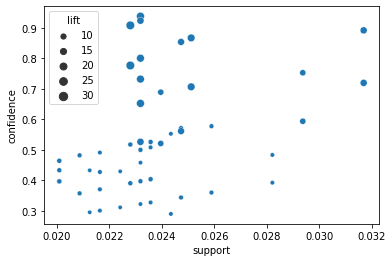

In [14]:
sns.scatterplot(x = "support", y = "confidence", 
                size = "lift", data = rules)
plt.show()

In [15]:
rules.to_csv('rules.csv',index=False)